In [1]:
import numpy as np
import functions_eq_mag as fc
import functions_fatiando as ft
from timeit import default_timer as time
from matplotlib import pyplot as plt
import pickle as pickle
%matplotlib inline

## Create the model

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 1000], [2000, 1000]]
#verts2 = [[-2000, 1000], [1000, 1000], [1000, 3000], [-2000, 3000]]
verts2 = [[-2000, 2000], [0, 2000], [0, 6000], [-2000, 6000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,0]}),
            ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':[2,2,0]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':[2,2,0]})]

In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(10.)
dec0 = np.deg2rad(37.)
inc = np.deg2rad(10.)
dec = np.deg2rad(37.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
with open('time_mag.pickle', 'rb') as r:
    time_mag = pickle.load(r)

# Time VS Observation points - Up to 22 500

### Calculate the time necessary to run the Classical Equivalent Layer

In [12]:
time_classical = []
N_shape = []
shape = [(10,10),(20,20),(30,30),(40,40),(50, 50),(60,60),(70,70),(80,80),(90,90),(100, 100),(150, 150)]
for i in range(len(shape)):
    xi, yi, zi = ft.gridder_regular(area, shape[i], z=-900.)

    tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
    tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
    tf = tf_prism + tf_sphere
    tf = ft.utils_contaminate(tf, 0.5, seed=0, percent=False)

    zj = np.ones_like(zi)*300
    N = shape[i][0]*shape[i][1]
    s = time()
    p_classic, dobs_classic = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
    e = time()
    tcpu_0 = e - s
    time_classical.append(tcpu_0)
    N_shape.append(N)

### Calculate the time necessary to run the CGLS Equivalent Layer

In [10]:
time_cgls = []
shape = [(10,10),(20,20),(30,30),(40,40),(50, 50),(60,60),(70,70),(80,80),(90,90),(100, 100),(150, 150)]
for i in range(len(shape)):
    xi, yi, zi = ft.gridder_regular(area, shape[i], z=-900.)

    tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
    tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
    tf = tf_prism + tf_sphere
    tf = ft.utils_contaminate(tf, 0.5, seed=0, percent=False)

    zj = np.ones_like(zi)*50

    itmax = 50
    s = time()
    p_cgls, dobs_cgls = fc.cgls_eq_mag(xi,yi,zi,zj,shape[i],tf,F,h,itmax)
    e = time()
    tcpu_cgls = e - s
    time_cgls.append(tcpu_cgls)

### Calculate the time necessary to run the CGLS_BCCB Equivalent Layer

In [13]:
time_bccb = []

for i in range(len(shape)):
    xi, yi, zi = ft.gridder_regular(area, shape[i], z=-900.)

    tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, np.rad2deg(inc0), np.rad2deg(dec0))
    tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, np.rad2deg(inc0), np.rad2deg(dec0))
    tf = tf_prism + tf_sphere
    tf = ft.utils_contaminate(tf, 0.5, seed=0, percent=False)

    zj = np.ones_like(zi)*50

    itmax = 50
    s = time()
    p_cgls_bccb, dobs_cgls_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape[i],tf,F,h,itmax)
    e = time()
    tcpu_bccb = e - s
    time_bccb.append(tcpu_bccb)

### Plot times

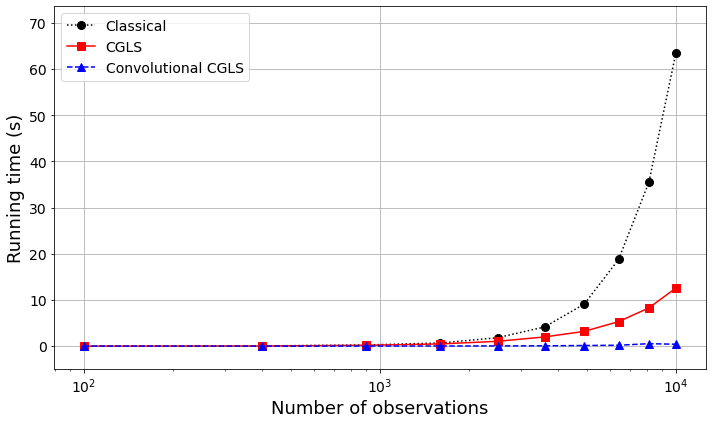

In [5]:
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('xkcd:white')
plt.semilogx(time_mag['shapes'][:-1], time_mag['classical'][:-1], 'ko:', alpha=1, markersize=8, label='Classical')
plt.semilogx(time_mag['shapes'][:-1], time_mag['cgls'][:-1], 'rs-', alpha=1, markersize=8, label='CGLS')
plt.semilogx(time_mag['shapes'][:-1], time_mag['cgls_bccb'][:-1], 'b^--', alpha=1, markersize=8, label='Convolutional CGLS')
#plt.axis('scaled')
#plt.xlim(np.min(N_time)-1,np.max(N_time)+1)
plt.ylim(np.min(time_mag['cgls_bccb'][:-1])-5,np.max(time_mag['classical'][:-1])+10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Number of observations', fontsize=18)
plt.ylabel('Running time (s)', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', fontsize=14);
#plt.savefig('figures/time_comparison_mag.png', dpi= 500)

In [31]:
time_mag = dict()
time_mag['shapes'] = N_shape
time_mag['classical'] = time_classical
time_mag['cgls'] = time_cgls
time_mag['cgls_bccb'] = time_bccb

In [33]:
#save the data
#file_name = 'time_mag.pickle'
#with open(file_name, 'wb') as f:
#    pickle.dump(time_mag, f)